<a href="https://colab.research.google.com/github/leonyangucl/2023fyp/blob/main/inpainting_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random

11490434/11490434 [==============================] - 2s 0us/step


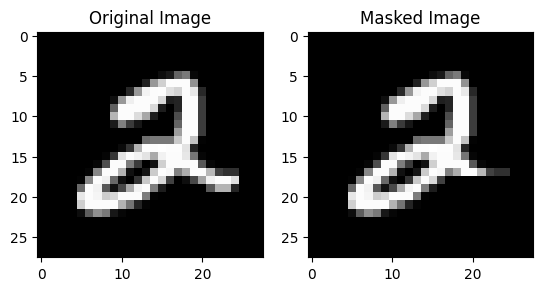

In [2]:

# load mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# example image
image = x_train[5]

image_copy = np.copy(image)

# we randomly mask this image
mask_size = 10
start_row = random.randint(0, image_copy.shape[0] - mask_size)
start_col = random.randint(0, image_copy.shape[1] - mask_size)

image_copy[start_row:start_row+mask_size, start_col:start_col+mask_size] = 0

# plot the two images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_copy, cmap='gray')
ax[1].set_title('Masked Image')
plt.show()


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train_noisy = x_train.copy()
x_test_noisy = x_test.copy()

mask_size = 10

#mask all the images
for img in x_train_noisy:
    row = random.randint(0, img.shape[0] - mask_size)
    col = random.randint(0, img.shape[1] - mask_size)
    img[row:row+mask_size, col:col+mask_size] = 0

for img in x_test_noisy:
    row = random.randint(0, img.shape[0] - mask_size)
    col = random.randint(0, img.shape[1] - mask_size)
    img[row:row+mask_size, col:col+mask_size] = 0

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape

# 定义编码器
encoder = Sequential()
encoder.add(Reshape((28, 28, 1), input_shape=(28, 28)))  # 将输入调整为4D以适应CNN
encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D((2, 2), padding='same'))
encoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder.add(MaxPooling2D((2, 2), padding='same'))

# 定义解码器
decoder = Sequential()
decoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 32)))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
decoder.add(Reshape((28, 28)))  # 将输出调整为2D

# 组合编码器和解码器
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 训练模型
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=128, validation_data=(x_test_noisy, x_test))


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.callbacks import EarlyStopping



model = Sequential([
    Reshape((28, 28, 1), input_shape=(28, 28)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),


    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
    Reshape((28, 28))
])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(x_train_noisy, x_train, epochs=50, batch_size=128, validation_data=(x_test_noisy, x_test), callbacks=[early_stop])

Epoch 1/50
469/469 [==============================] - 18s 7ms/step - loss: 0.1704 - val_loss: 0.1238
Epoch 2/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1170 - val_loss: 0.1109
Epoch 3/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1092 - val_loss: 0.1073
Epoch 4/50
469/469 [==============================] - 3s 5ms/step - loss: 0.1051 - val_loss: 0.1031
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1024 - val_loss: 0.1004
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1003 - val_loss: 0.1000
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0990 - val_loss: 0.0979
Epoch 8/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0977 - val_loss: 0.0965
Epoch 9/50
469/469 [==============================] - 3s 5ms/step - loss: 0.0966 - val_loss: 0.0960
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0959 - val_loss: 0.095

313/313 [==============================] - 1s 2ms/step


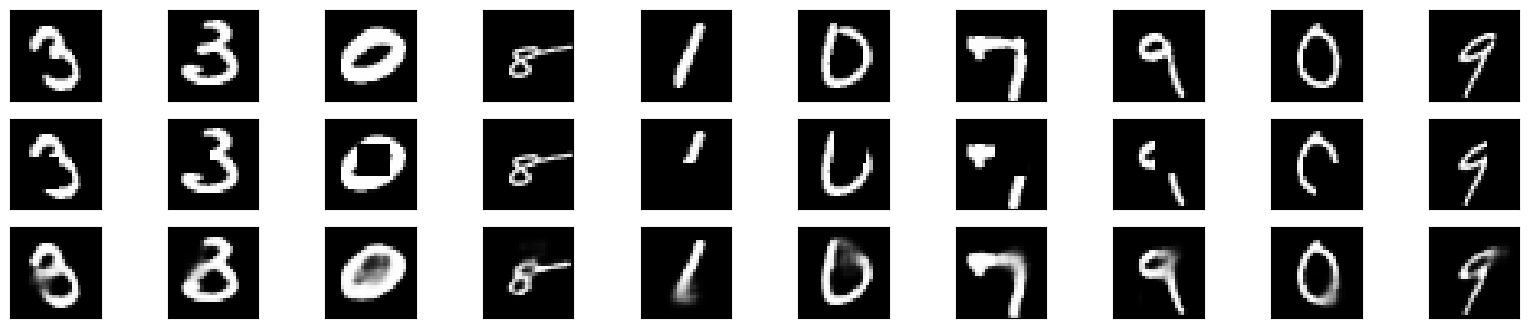

In [7]:
import numpy as np

decoded_imgs = model.predict(x_test_noisy)

n = 10
random_test_images = np.random.choice(x_test_noisy.shape[0], size=n)

plt.figure(figsize=(20, 4))
for i, image_idx in enumerate(random_test_images):
    # original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # masked images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # fixed images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

simple unet

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def create_model():
    inputs = Input((28, 28, 1))

    # encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # decoder
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    up1 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)

    # output layer
    conv5 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    model = Model(inputs=[inputs], outputs=[conv5])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 128)  73856       ['max_pooling2d_2[0][0]']        
                                                                                              

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(x_train_noisy, x_train, epochs=50, batch_size=128, validation_data=(x_test_noisy, x_test), callbacks=[early_stop])

Epoch 1/50
469/469 [==============================] - 12s 19ms/step - loss: 0.1248 - val_loss: 0.0953
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0920 - val_loss: 0.0892
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0874 - val_loss: 0.0857
Epoch 4/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0847 - val_loss: 0.0833
Epoch 5/50
469/469 [==============================] - 8s 18ms/step - loss: 0.0830 - val_loss: 0.0820
Epoch 6/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0819 - val_loss: 0.0822
Epoch 7/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0808 - val_loss: 0.0803
Epoch 8/50
469/469 [==============================] - 8s 18ms/step - loss: 0.0800 - val_loss: 0.0800
Epoch 9/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0792 - val_loss: 0.0792
Epoch 10/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0786 - val_l

313/313 [==============================] - 1s 2ms/step


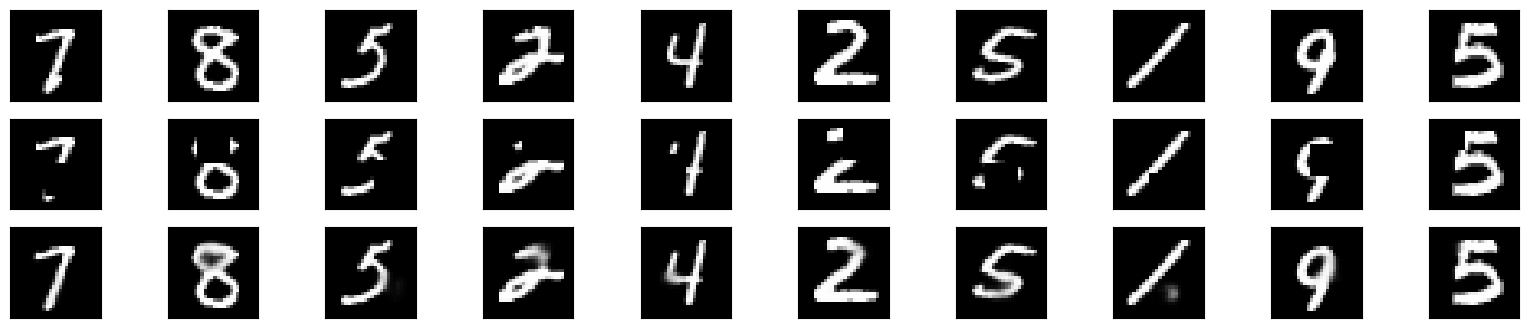

In [13]:
import numpy as np

decoded_imgs = model.predict(x_test_noisy)

n = 10
random_test_images = np.random.choice(x_test_noisy.shape[0], size=n)

plt.figure(figsize=(20, 4))
for i, image_idx in enumerate(random_test_images):
    # original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # masked images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # fixed images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
